# Using Quantum Kernels for classifcation of Images



Installing required packages Add 

In [13]:
#pip install tensorflow

In [14]:
#pip install pylatexenc

In [15]:
#pip install qiskit

In [16]:
#pip install qiskit_machine_learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
import time
from pylatexenc import *

time1 = time.time()
# Set a random seed for reproducibility
np.random.seed(1001)
###############################################################################
#Data we Will be using
###############################################################################
import tarfile
import pickle
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA

import matplotlib.ticker as ticker

C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3682672223.py:7: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


# Classical Definitions - Preprocessing the Data

In [2]:
def load_cifar10_data(file_path):
    with tarfile.open(file_path, "r:gz") as tar:
        train_data = []
        Y_train = []
        for member in tar.getmembers():
            if "data_batch" in member.name:
                with tar.extractfile(member) as f:
                    data_dict = pickle.load(f, encoding="bytes")
                    train_data.append(data_dict[b"data"])
                    Y_train.extend(data_dict[b"labels"])

        train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        Y_train = np.array(Y_train)

        with tar.extractfile("cifar-10-batches-py/test_batch") as f:
            data_dict = pickle.load(f, encoding="bytes")
            X_test = data_dict[b"data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
            Y_test = np.array(data_dict[b"labels"])

    return (train_data, Y_train), (X_test, Y_test)

def preprocess_images(images, size=32):
    #images_resized = tf.image.resize(images, [size, size])
    images_normalized = images / 255.0
    #images_gray = tf.image.rgb_to_grayscale(images_normalized)
    return images_normalized

def filter_and_preprocess_data(train_images, Y_train, test_images, Y_test, num_training_points, num_testing_points, num_PCA_componants, Disp= True):
    cat_dog_filter_train = (Y_train == 3).flatten() | (Y_train == 5).flatten()
    cat_dog_filter_test = (Y_test == 3).flatten() | (Y_test == 5).flatten()

    X_train = train_images[cat_dog_filter_train]
    Y_train = Y_train[cat_dog_filter_train]
    X_test = test_images[cat_dog_filter_test]
    Y_test = Y_test[cat_dog_filter_test]

    # Convert labels: cat (3) -> -1, dog (5) -> 1
    Y_train = (Y_train / 5).astype(int)
    Y_train = np.where(Y_train == 0, -1, 1)
    Y_test = (Y_test / 5).astype(int)
    Y_test = np.where(Y_test == 0, -1, 1)

    # Preprocess the images
    X_train = preprocess_images(X_train)
    X_test = preprocess_images(X_test)

    # Separate cats and dogs indices
    cat_indices_train = np.where(Y_train == -1)[0]
    dog_indices_train = np.where(Y_train == 1)[0]
    cat_indices_test = np.where(Y_test == -1)[0]
    dog_indices_test = np.where(Y_test == 1)[0]

    # Randomly select equal number of cats and dogs for training and testing
    half_training = num_training_points // 2
    half_testing = num_testing_points // 2

    random_cat_train_indices = np.random.choice(cat_indices_train, half_training, replace=False)
    random_dog_train_indices = np.random.choice(dog_indices_train, half_training, replace=False)
    random_cat_test_indices = np.random.choice(cat_indices_test, half_testing, replace=False)
    random_dog_test_indices = np.random.choice(dog_indices_test, half_testing, replace=False)

    selected_train_indices = np.concatenate([random_cat_train_indices, random_dog_train_indices])
    selected_test_indices = np.concatenate([random_cat_test_indices, random_dog_test_indices])

    X_train = X_train[selected_train_indices]
    Y_train = Y_train[selected_train_indices]
    X_test = X_test[selected_test_indices]
    Y_test = Y_test[selected_test_indices]

    # Flatten and PCA
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
    print("Number of components before PCA:", X_train_flattened.shape[1])
    pca = PCA(n_components=num_PCA_componants)
    X_train_reduced = pca.fit_transform(X_train_flattened)
    X_test_reduced = pca.transform(X_test_flattened)

    # Fit the PCA model
    pca = PCA(n_components=num_PCA_componants)
    pca.fit(X_train_flattened)
    if Disp == True:   
        # Calculate cumulative explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        
        # Find the component for each threshold
        thresholds = np.arange(0.1, 1.1, 0.1)
        components_for_thresholds = [np.argmax(cumulative_variance > threshold) for threshold in thresholds]
        
        # Plot the explained variance
        plt.plot(cumulative_variance)
        plt.gca().set_xscale('symlog')  # Set x-axis to symmetrical log scale
        plt.gca().xaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 5, 10, 50, 100, 500, 1000, 2000, 3072]))  # Set fixed locations for x-axis ticks
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by Components')
        
        # Set the x-ticks to be the component numbers
        plt.xticks(components_for_thresholds, components_for_thresholds)
        
        plt.grid(True)
        plt.show()
    return X_train_reduced, Y_train, X_test_reduced, Y_test

# Compute classical SVM score using reduced data
def classical_kernel(X_train_reduced, Y_train, X_test_reduced, Y_test):
    svc = SVC()
    svc.fit(X_train_reduced, Y_train)
    classical_svm_score = svc.score(X_test_reduced, Y_test)
    return classical_svm_score

# Quantum Circuit definitions

In [3]:
# Define Quantum Embedding Kernel
def  paramater_vector(num_features): 
    '''Embed classical states onto the quantum computer'''
    # Define training parameter vector
    training_params = ParameterVector("θ", num_features)

    # Create the QuantumCircuit fm0
    fm0 = QuantumCircuit(num_features)
    for i in range(num_features):
        fm0.ry(training_params[i], i)

    return fm0
def ZZ_feature_embedding(num_features):
    '''Embed classical states onto the quantum computer'''
    # Define training parameter vector
    training_params = ParameterVector("θ", num_features)

    # Create the QuantumCircuit fm0
    fm0 = QuantumCircuit(num_features)
    for i in range(num_features):
        fm0.ry(training_params[i], i)


    # Define ZZFeatureMap
    fm1 = ZZFeatureMap(feature_dimension=num_features, reps=1, entanglement='linear')

    # Compose the feature map
    feature_map = fm0.compose(fm1)
    plt.show()
    return feature_map, training_params

# Define kernel function using FidelityQuantumKernel
def kernel(feature_map):
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quant_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map, evaluate_duplicates='off_diagonal')
    return quant_kernel

# Perform quantum SVM classification using precomputed kernel
def quantum_svm(kernel_matrix_train, kernel_matrix_test, Y_train, Y_test):
    svc = SVC(kernel="precomputed")
    svc.fit(kernel_matrix_train, Y_train)
    score_precomputed_kernel = svc.score(kernel_matrix_test, Y_test)
    print(f"Precomputed kernel classification test score: {score_precomputed_kernel}")

# Compute Kernel-Target Alignment (KTA)
def KTA(K, y, y_outer):
    """Compute the kernel-target alignment."""
    denominator = np.sqrt(np.trace(K @ K) * np.trace(y_outer @ y_outer)) + 1e-10
    return (y.T @ K @ y) / denominator

# Compute gradient of KTA for optimization
kta_values = []
def KTA_gradient(thetas, X, Y, y_outer,delta_theta=1e-6):
    gradients = []
    for i, theta in enumerate(thetas):
        theta_shifted = np.copy(thetas)
        theta_shifted[i] += delta_theta

        bound_map_original = feature_map.assign_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
        kernel_matrix_train_original = kernel(bound_map_original).evaluate(x_vec=X)
        kta_original = KTA(kernel_matrix_train_original, Y, y_outer)

        bound_map_shifted = feature_map.assign_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})
        kernel_matrix_train_shifted = kernel(bound_map_shifted).evaluate(x_vec=X)
        kta_shifted = KTA(kernel_matrix_train_shifted, Y, y_outer)

        gradient = (kta_shifted - kta_original) / delta_theta
        gradients.append(gradient)
    print(kta_original)
    kta_values.append(kta_original)
    #print(gradients)
    return np.array(gradients)


# Plot kernel matrices for visualization
def plot_matrix(matrix_train, matrix_test, matrix_train_optimal, matrix_test_optimal):
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    axs[0, 0].imshow(
        np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
    )
    axs[0, 0].set_title("Training kernel matrix")

    axs[0, 1].imshow(
        np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds"
    )
    axs[0, 1].set_title("Testing kernel matrix")

    axs[1, 0].imshow(
        np.asmatrix(matrix_train_optimal), interpolation="nearest", origin="upper", cmap="Blues"
    )
    axs[1, 0].set_title("Optimal Training kernel matrix")

    axs[1, 1].imshow(
        np.asmatrix(matrix_test_optimal), interpolation="nearest", origin="upper", cmap="Reds"
    )
    axs[1, 1].set_title("Optimal Testing kernel matrix")

    plt.tight_layout()
    plt.show()

## Testing Functions

## Harsh Kenrel

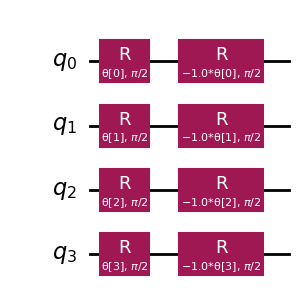

In [4]:
test_num_qubits = 4

test_circuit = QuantumCircuit(test_num_qubits)

# The data is a list of random 0's and 1's 
data_point_1 = [np.random.randint(0, 2) for _ in range(test_num_qubits)]
data_point_2 = [np.random.randint(0, 2) for _ in range(test_num_qubits)]


# Need to scale bwtweem 0 and Pi to make the 0 orthogonal to 1 
data_point_1 = [x * np.pi for x in data_point_1]
data_point_2 = [x * np.pi for x in data_point_2]


test_circuit = paramater_vector(test_num_qubits)

# Creating the circuit drawing
test_circuit_draw = test_circuit.compose(test_circuit.inverse())
test_circuit_draw.decompose().draw('mpl', style='iqx')


In [5]:
kernel_matrix = kernel(test_circuit).evaluate(data_point_1,data_point_2)
print(f"Data point 1: {data_point_1}\nData point 2 {data_point_2}")
print(f"Kernel socore between the two data points: {kernel_matrix}")

Data point 1: [3.141592653589793, 3.141592653589793, 3.141592653589793, 0.0]
Data point 2 [0.0, 3.141592653589793, 0.0, 0.0]
Kernel socore between the two data points: [[0.]]


## Paramater Vector and ZZfeaureMap Kernel

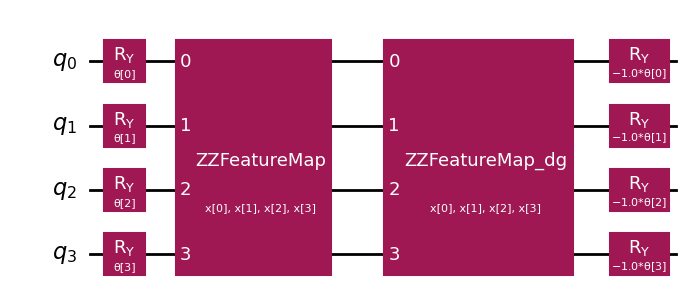

In [10]:
test_num_qubits = 4

# The data is a list of random 0's and 1's 
data_point_1 = [np.random.randint(0, 2) for _ in range(test_num_qubits*2)]
data_point_2 = [np.random.randint(0, 2) for _ in range(test_num_qubits*2)]


# Need to scale bwtweem 0 and Pi to make the 0 orthogonal to 1 
data_point_1 = [x * np.pi for x in data_point_1]
data_point_2 = [x * np.pi for x in data_point_2]

feature_map, training_params = ZZ_feature_embedding(test_num_qubits)

test_circuit_draw = QuantumCircuit(test_num_qubits)
test_circuit_draw = test_circuit_draw.compose(feature_map)
test_circuit_draw = test_circuit_draw.compose(feature_map.inverse())
test_circuit_draw.draw('mpl', style='iqp')

In [11]:
# This is an exaple of hoe the ZZFeatureMap Kernel works with trainable variable paramaters at the beginning and end of the circuit
kernel_matrix = kernel(feature_map).evaluate(data_point_1,data_point_2)
print(f"Data point 1: {data_point_1}\nData point 2 {data_point_2}")
print(f"Kernel socore between the two data points: {kernel_matrix}")

Data point 1: [0.0, 0.0, 3.141592653589793, 0.0, 3.141592653589793, 0.0, 0.0, 3.141592653589793]
Data point 2 [0.0, 0.0, 3.141592653589793, 3.141592653589793, 3.141592653589793, 0.0, 0.0, 0.0]
Kernel socore between the two data points: [[0.]]


# Loading in the Data set

In [12]:
# Load CIFAR-10 dataset and preprocess data
file_path = r"cifar-10-python.tar.gz" # You should adjust this to the path of your CIFAR-10 dataset tarball
(train_images, Y_train_original), (test_images, Y_test_original) = load_cifar10_data(file_path)

Number of components before PCA: 3072


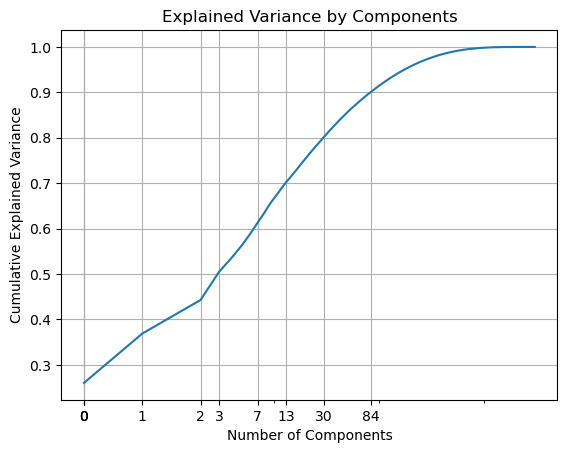

In [13]:
# Define the number of training/testing points, PCA components, and quantum circuit layers
# To find how many features represent 80% of the varience in the data
num_training_points = 4000
num_testing_points = 100
num_features = 3072

# Filter and preprocess data
X_train, Y_train, X_test, Y_test = filter_and_preprocess_data(train_images, Y_train_original, test_images, Y_test_original, num_training_points, num_testing_points, num_features)

### We can see that 14 features can represent 70% of the data, 31 features represent 80% of the data and 84 features represent 90% of the data. We ue x features do to the limitaions of the simulator available.

In [46]:
num_training_points = 100
num_testing_points = 50
num_features = 4

# Filter and preprocess data
X_train, Y_train, X_test, Y_test = filter_and_preprocess_data(train_images, Y_train_original, test_images, Y_test_original, num_training_points, num_testing_points, num_features, Disp = False)

Number of components before PCA: 3072


## Testing the Data with a classical RBF kernel

In [47]:
# Test using classical RBF SVM
classical_svm_score = classical_kernel(X_train, Y_train, X_test, Y_test)
print(f"Classical rbf kernel classification test score: {classical_svm_score}")

Classical rbf kernel classification test score: 0.46


In [48]:
 # Test with random (untrained) parameters
feature_map, training_params = ZZ_feature_embedding(num_features)
#theta = [1.2566370614359172, 3.141592653589793, 2.5132741228718345, 0.0] #some trained params
theta = np.random.uniform(0,2*np.pi,num_features)
# Optimal theta: [5.201432097848048, 0.16795640707114898, 2.340889651896597, -0.06494248625237167]
bound_map = feature_map.assign_parameters({training_params[i]: theta[i] for i in range(num_features)})

In [49]:
kernel_matrix_train = kernel(bound_map).evaluate(x_vec=X_train)

In [50]:
kernel_matrix_test = kernel(bound_map).evaluate(x_vec=X_test, y_vec=X_train)

In [51]:
quantum_svm(kernel_matrix_train, kernel_matrix_test, Y_train, Y_test)

Train SVM Score: 0.76, Test SVM Score: 0.56


In [52]:
# Calculate and display the initial KTA
y_outer = np.outer(Y_train, Y_train) #can optimise becuase you only need this once
kta = KTA(kernel_matrix_train, Y_train, y_outer)
print("Initial KTA:", kta)


Initial KTA: 0.037530821138969196


## Gradient Free Optimisation

In [53]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
import pandas as pd
print(f'N Features - {num_features} N Qubits - {num_qubits}')

# Define a list to store KTA values at each iteration
kta_history = []
train_validation = []
test_validation = []

# Modify the callback function to calculate and save the SVM scores
def save_kta_per_iteration(thetas):
    global time4
    current_kta = -objective_function(thetas, X_train, Y_train, y_outer, feature_map, training_params)
    kta_history.append(current_kta)
    time3 = time.time()
    print(f"Iteration {len(kta_history)} - KTA: {current_kta} - Time: {time3-time4}")
    time4 = time3
    # Every 10 iterations, calculate the SVM score for both the training and testing sets
    if len(kta_history) % 10 == 0:
        # Update the feature map with the current thetas
        bound_map_current = feature_map.assign_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
        
        # Calculate the current kernel matrices
        kernel_matrix_train_current = kernel(bound_map_current).evaluate(x_vec=X_train)
        kernel_matrix_test_current = kernel(bound_map_current).evaluate(x_vec=X_test, y_vec=X_train)
        
        # Calculate the SVM scores
        current_train_score, current_test_score = quantum_svm(kernel_matrix_train_current, kernel_matrix_test_current, Y_train, Y_test, return_scores=True)
        
        # Save the scores
        train_validation.append(current_train_score)
        test_validation.append(current_test_score)

        print(f"Iteration {len(kta_history)} - Train SVM Score: {current_train_score}, Test SVM Score: {current_test_score}")

def quantum_svm(kernel_matrix_train, kernel_matrix_test, Y_train, Y_test, return_scores=False):
    svc = SVC(kernel="precomputed")
    svc.fit(kernel_matrix_train, Y_train)
    train_score = svc.score(kernel_matrix_train, Y_train)
    test_score = svc.score(kernel_matrix_test, Y_test)
    if return_scores:
        return train_score, test_score
    else:
        print(f"Train SVM Score: {train_score}, Test SVM Score: {test_score}")
        

# Get the feature map and training parameters
feature_map, training_params = ZZ_feature_embedding(num_features)

# Define initial parameters for optimization
initial_theta = np.random.uniform(0, 2*np.pi, num_features)

# Record the start time
t1 = time.time()
global time4
time4 = time.time()
# Run the Nelder-Mead optimization
result = minimize(
    objective_function, 
    initial_theta, 
    args=(X_train, Y_train, y_outer, feature_map, training_params),
    method='Nelder-Mead',
    callback=save_kta_per_iteration,  # Pass the callback function
    options={'maxiter': 120, 'xatol': 1e-3, 'fatol': 1e-3, 'disp': True}
)

# Extract the optimal parameters
optimal_theta = result.x
print("Optimal theta:", optimal_theta)

# Record the end time and calculate the elapsed time
t2 = time.time()
print(t2-t1, 'seconds')

# Calculate the kernel matrix using the optimal parameters
bound_map_optimal = feature_map.assign_parameters({training_params[i]: optimal_theta[i] for i in range(len(optimal_theta))})
kernel_matrix_train_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_train)
kernel_matrix_test_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_test, y_vec=X_train)

# Perform quantum SVM classification using precomputed kernel with optimal parameters
quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test)

N Features - 4 N Qubits - 2


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 1 - KTA: 0.04069175511633449 - Time: 357.02906036376953
Iteration 2 - KTA: 0.041673776272846526 - Time: 136.254638671875
Iteration 3 - KTA: 0.04483583263014001 - Time: 136.32313179969788
Iteration 4 - KTA: 0.04483583263014001 - Time: 137.03296446800232
Iteration 5 - KTA: 0.04483583263014001 - Time: 133.71810460090637
Iteration 6 - KTA: 0.0487802565694739 - Time: 136.9567220211029
Iteration 7 - KTA: 0.0487802565694739 - Time: 94.25331020355225
Iteration 8 - KTA: 0.05650191811568149 - Time: 138.93618988990784
Iteration 9 - KTA: 0.05650191811568149 - Time: 91.98808646202087
Iteration 10 - KTA: 0.05650191811568149 - Time: 87.28265047073364
Iteration 10 - Train SVM Score: 0.87, Test SVM Score: 0.58


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 11 - KTA: 0.05650191811568149 - Time: 230.52662539482117
Iteration 12 - KTA: 0.05863645528852244 - Time: 142.91130781173706
Iteration 13 - KTA: 0.05863645528852244 - Time: 90.01893711090088
Iteration 14 - KTA: 0.06387591987649936 - Time: 146.1187722682953
Iteration 15 - KTA: 0.06387591987649936 - Time: 100.6063506603241
Iteration 16 - KTA: 0.06764369108319451 - Time: 157.3821415901184
Iteration 17 - KTA: 0.06764369108319451 - Time: 149.38186740875244
Iteration 18 - KTA: 0.07511055998330625 - Time: 153.27382159233093
Iteration 19 - KTA: 0.07511055998330625 - Time: 96.8030219078064
Iteration 20 - KTA: 0.07511055998330625 - Time: 105.67521595954895
Iteration 20 - Train SVM Score: 0.9, Test SVM Score: 0.58


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 21 - KTA: 0.07511055998330625 - Time: 212.1355857849121
Iteration 22 - KTA: 0.07511055998330625 - Time: 99.24842190742493
Iteration 23 - KTA: 0.07511055998330625 - Time: 151.68511748313904
Iteration 24 - KTA: 0.07511055998330625 - Time: 102.70465469360352
Iteration 25 - KTA: 0.07511055998330625 - Time: 150.65967893600464
Iteration 26 - KTA: 0.07511055998330625 - Time: 145.66568875312805
Iteration 27 - KTA: 0.07759792045229194 - Time: 155.65637493133545
Iteration 28 - KTA: 0.07759792045229194 - Time: 99.68536305427551
Iteration 29 - KTA: 0.07759792045229194 - Time: 99.5987000465393
Iteration 30 - KTA: 0.07759792045229194 - Time: 106.1529426574707
Iteration 30 - Train SVM Score: 0.91, Test SVM Score: 0.58


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 31 - KTA: 0.07940473021930002 - Time: 255.19906663894653
Iteration 32 - KTA: 0.07940473021930002 - Time: 103.17064332962036
Iteration 33 - KTA: 0.07940473021930002 - Time: 154.416601896286
Iteration 34 - KTA: 0.07940473021930002 - Time: 156.99292016029358
Iteration 35 - KTA: 0.07940473021930002 - Time: 99.99230551719666
Iteration 36 - KTA: 0.0794740918570026 - Time: 152.7057523727417
Iteration 37 - KTA: 0.07951720118333494 - Time: 150.6968846321106
Iteration 38 - KTA: 0.07951720118333494 - Time: 103.33335304260254
Iteration 39 - KTA: 0.07951720118333494 - Time: 102.21922206878662
Iteration 40 - KTA: 0.07958374448484244 - Time: 152.23688507080078
Iteration 40 - Train SVM Score: 0.94, Test SVM Score: 0.52


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 41 - KTA: 0.07958374448484244 - Time: 252.7619469165802
Iteration 42 - KTA: 0.07960694673090662 - Time: 153.59109807014465
Iteration 43 - KTA: 0.07961497323997559 - Time: 154.58505725860596
Iteration 44 - KTA: 0.07961567768277777 - Time: 150.41829681396484
Iteration 45 - KTA: 0.07964504146555726 - Time: 146.83645939826965
Iteration 46 - KTA: 0.07964504146555726 - Time: 158.0921483039856
Iteration 47 - KTA: 0.07964504146555726 - Time: 98.91792058944702
Iteration 48 - KTA: 0.07965265528807661 - Time: 157.04387068748474
Iteration 49 - KTA: 0.07965871873726244 - Time: 152.68027877807617
Iteration 50 - KTA: 0.079663312672 - Time: 149.5026843547821
Iteration 50 - Train SVM Score: 0.94, Test SVM Score: 0.52


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 51 - KTA: 0.07966397444423626 - Time: 256.9752902984619
Iteration 52 - KTA: 0.07966565948668479 - Time: 157.62601590156555
Iteration 53 - KTA: 0.07966836350809126 - Time: 155.83176016807556
Iteration 54 - KTA: 0.07968441661249898 - Time: 148.1449670791626
Iteration 55 - KTA: 0.07968441661249898 - Time: 153.44742393493652
Iteration 56 - KTA: 0.07968441661249898 - Time: 100.20324850082397
Iteration 57 - KTA: 0.0797112906247033 - Time: 159.4832878112793
Iteration 58 - KTA: 0.0797112906247033 - Time: 98.94310927391052
Iteration 59 - KTA: 0.0797112906247033 - Time: 101.64914870262146
Iteration 60 - KTA: 0.0797112906247033 - Time: 101.35063862800598
Iteration 60 - Train SVM Score: 0.94, Test SVM Score: 0.52


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 61 - KTA: 0.0797112906247033 - Time: 211.29550051689148
Iteration 62 - KTA: 0.07971445394836676 - Time: 150.14083671569824
Iteration 63 - KTA: 0.07976188308775979 - Time: 151.36179208755493
Iteration 64 - KTA: 0.07976188308775979 - Time: 100.11960673332214
Iteration 65 - KTA: 0.07976188308775979 - Time: 105.66324400901794
Iteration 66 - KTA: 0.07980529472682346 - Time: 150.5984754562378
Iteration 67 - KTA: 0.07982428207090478 - Time: 154.36149644851685
Iteration 68 - KTA: 0.07988809574471813 - Time: 153.5212516784668
Iteration 69 - KTA: 0.07995720322648994 - Time: 147.56725931167603
Iteration 70 - KTA: 0.08012525127284183 - Time: 153.15067291259766
Iteration 70 - Train SVM Score: 0.94, Test SVM Score: 0.54


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 71 - KTA: 0.08012525127284183 - Time: 202.91711258888245
Iteration 72 - KTA: 0.08038065726553167 - Time: 152.22519063949585
Iteration 73 - KTA: 0.08038065726553167 - Time: 97.19934320449829
Iteration 74 - KTA: 0.08070906103757133 - Time: 159.06867098808289
Iteration 75 - KTA: 0.08070906103757133 - Time: 100.03465342521667
Iteration 76 - KTA: 0.08116843430934764 - Time: 157.7480664253235
Iteration 77 - KTA: 0.08116843430934764 - Time: 99.28949332237244
Iteration 78 - KTA: 0.08136043235961854 - Time: 157.82897424697876
Iteration 79 - KTA: 0.08136043235961854 - Time: 101.42147445678711
Iteration 80 - KTA: 0.08136043235961854 - Time: 97.61281085014343
Iteration 80 - Train SVM Score: 0.92, Test SVM Score: 0.56


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 81 - KTA: 0.08137171068985821 - Time: 258.0793538093567
Iteration 82 - KTA: 0.08140620039868841 - Time: 158.59243869781494
Iteration 83 - KTA: 0.08142130939525102 - Time: 149.36381649971008
Iteration 84 - KTA: 0.08142978855736227 - Time: 157.2463161945343
Iteration 85 - KTA: 0.08142978855736227 - Time: 99.43884491920471
Iteration 86 - KTA: 0.08142978855736227 - Time: 103.55868101119995
Iteration 87 - KTA: 0.08147194573217577 - Time: 152.9745705127716
Iteration 88 - KTA: 0.08147194573217577 - Time: 156.1371614933014
Iteration 89 - KTA: 0.08147194573217577 - Time: 151.61915230751038
Iteration 90 - KTA: 0.08147194573217577 - Time: 150.85152292251587
Iteration 90 - Train SVM Score: 0.93, Test SVM Score: 0.54


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 91 - KTA: 0.08148418435916732 - Time: 262.6388018131256
Iteration 92 - KTA: 0.08148418435916732 - Time: 157.37560868263245
Iteration 93 - KTA: 0.08148624631716388 - Time: 152.68190121650696
Iteration 94 - KTA: 0.08148624631716388 - Time: 103.57859086990356
Iteration 95 - KTA: 0.08148659879788708 - Time: 147.61944365501404
Iteration 96 - KTA: 0.08148980628540074 - Time: 156.29601907730103
Iteration 97 - KTA: 0.08148980628540074 - Time: 164.05882859230042
Iteration 98 - KTA: 0.0814900063388024 - Time: 154.11754870414734
Iteration 99 - KTA: 0.08149156264212393 - Time: 153.6151852607727
Iteration 100 - KTA: 0.08149156264212393 - Time: 101.39056491851807
Iteration 100 - Train SVM Score: 0.92, Test SVM Score: 0.54


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 101 - KTA: 0.08149156264212393 - Time: 262.52015447616577
Iteration 102 - KTA: 0.0814917632157939 - Time: 160.66430377960205
Iteration 103 - KTA: 0.0814917632157939 - Time: 154.35660409927368
Iteration 104 - KTA: 0.08149207717811688 - Time: 152.85131764411926
Iteration 105 - KTA: 0.08149207717811688 - Time: 159.47086834907532
Iteration 106 - KTA: 0.08149207717811688 - Time: 156.98356294631958
Iteration 107 - KTA: 0.08149212502944508 - Time: 151.49159955978394
Iteration 108 - KTA: 0.08149212502944508 - Time: 104.63946986198425
Iteration 109 - KTA: 0.08149212502944508 - Time: 104.86846232414246
Iteration 110 - KTA: 0.08149216342611916 - Time: 147.20773220062256
Iteration 110 - Train SVM Score: 0.92, Test SVM Score: 0.54


C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\2581699462.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})


Iteration 111 - KTA: 0.08149216524815092 - Time: 258.86128067970276
Iteration 112 - KTA: 0.08149218853416941 - Time: 158.01296043395996
Iteration 113 - KTA: 0.08149220233468184 - Time: 157.12630081176758
Iteration 114 - KTA: 0.08149220665049223 - Time: 149.47985577583313
Iteration 115 - KTA: 0.08149220665049223 - Time: 104.23231410980225
Iteration 116 - KTA: 0.08149221108578397 - Time: 152.13626766204834
Iteration 117 - KTA: 0.08149221430211397 - Time: 156.26323580741882
Iteration 118 - KTA: 0.08149221536906855 - Time: 157.01456952095032
Iteration 119 - KTA: 0.08149221536906855 - Time: 46.77872610092163
Optimization terminated successfully.
         Current function value: -0.081492
         Iterations: 119
         Function evaluations: 202
Optimal theta: [ 6.70195334  6.2295602  -0.03590189  3.3650391 ]
17374.03459763527 seconds
Train SVM Score: 0.92, Test SVM Score: 0.54


Optimization details saved to optimization_details.csv


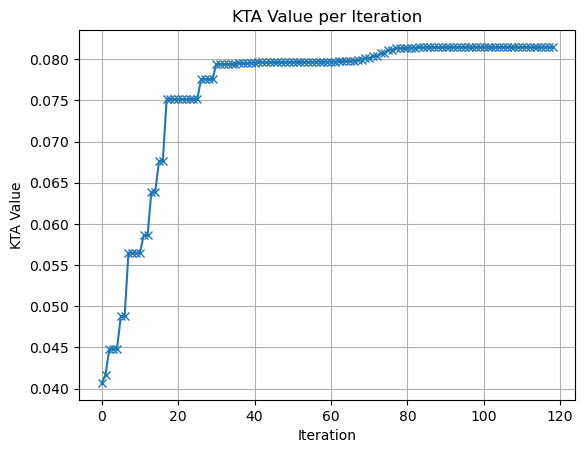

In [54]:
import os
# Perform quantum SVM classification using precomputed kernel with optimal parameters
train_score, test_score = quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test, return_scores=True)

# Store the results in a DataFrame
optimization_details = {
    'Optimization Method': ['Nelder-Mead'],
    'Num Qubits': [num_features],
    'Num Iterations': [len(kta_history)],
    'SVM Train Score': [train_score],
    'SVM Test Score': [test_score],
    'KTA List': [kta_history],
    'Optimised Weights': [optimal_theta.tolist()]
}

# Define the CSV file path
csv_file_path = 'optimization_details.csv'

# Check if the file already exists
if os.path.isfile(csv_file_path):
    # Load the existing CSV file into a DataFrame
    df_existing = pd.read_csv(csv_file_path)
    
    # Append the new data to the existing DataFrame
    df_new = pd.DataFrame(optimization_details)
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    
    # Save the combined DataFrame to the CSV file
    df_combined.to_csv(csv_file_path, index=False)
else:
    # If the file doesn't exist, save the new data as a new CSV file
    df = pd.DataFrame(optimization_details)
    df.to_csv(csv_file_path, index=False)

print(f"Optimization details saved to {csv_file_path}")
# Plot the KTA values over iterations
plt.plot(kta_history, marker='x')
plt.xlabel('Iteration')
plt.ylabel('KTA Value')
plt.title('KTA Value per Iteration')
plt.grid(True)
plt.show()



In [57]:
train_vali1, test_vali1  = train_validation, test_validation

## Gradient Based Optimisation with a decay

### Batched Gradient Acent

In [75]:
train_validation = []
test_validation = []

# Modify the gradient_ascent function
def gradient_ascent(theta, X_train, Y_train, y_outer, num_iterations, initial_learning_rate, decay_rate, batch_size):
    kta_values = []
    thetas = np.copy(theta)

    for iteration in range(num_iterations):
        current_learning_rate = initial_learning_rate / (1 + decay_rate * iteration)

        # Randomly select a batch of data points
        idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
        X_batch = X_train[idx]
        Y_batch = Y_train[idx]

        # Compute the gradient using this batch
        gradient = KTA_gradient(thetas, X_batch, Y_batch, y_outer)
        kta_current = KTA(kernel(feature_map.assign_parameters({training_params[i]: thetas[i] for i in range(len(thetas))})).evaluate(x_vec=X_batch), Y_batch, y_outer)
        kta_values.append(kta_current)

        # Update the parameter using the calculated gradient
        thetas += current_learning_rate * gradient
        print(f"Iteration {len(kta_values)} - KTA: {kta_current}")
        
        # Every 10 iterations, calculate the SVM score for both the training and testing sets
        if (iteration + 1) % 20 == 0:
            bound_map_current = feature_map.assign_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
            kernel_matrix_train_current = kernel(bound_map_current).evaluate(x_vec=X_train)
            kernel_matrix_test_current = kernel(bound_map_current).evaluate(x_vec=X_test, y_vec=X_train)
            current_train_score, current_test_score = quantum_svm(kernel_matrix_train_current, kernel_matrix_test_current, Y_train, Y_test, return_scores=True)
            train_validation.append(current_train_score)
            test_validation.append(current_test_score)
            print(f"Iteration {len(kta_values)} - Train SVM Score: {current_train_score}, Test SVM Score: {current_test_score}")

    return thetas, kta_values

# Set optimization parameters
initial_theta = np.random.uniform(0, 2 * np.pi, num_features)
num_iterations = 120
initial_learning_rate = 0.9
decay_rate = 1
batch_size = 20

# Perform gradient ascent
t1 = time.time()
optimal_theta, kta_values = gradient_ascent(initial_theta, X_train, Y_train, y_outer, num_iterations, initial_learning_rate, decay_rate, batch_size)
t2 = time.time()

# Calculate the kernel matrix using the optimal parameters
bound_map_optimal = feature_map.assign_parameters({training_params[i]: optimal_theta[i] for i in range(len(optimal_theta))})
kernel_matrix_train_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_train)
kernel_matrix_test_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_test, y_vec=X_train)

# Perform quantum SVM classification using precomputed kernel with optimal parameters
svm_score = quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test)

C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:64: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})


0.009332706967013897
Iteration 1 - KTA: 0.009332706967013897
0.013381580859680537
Iteration 2 - KTA: 0.013381580859680537
0.02647465479901471
Iteration 3 - KTA: 0.02647465479901471
0.04591199439800949
Iteration 4 - KTA: 0.04591199439800949
0.03126680276896168
Iteration 5 - KTA: 0.03126680276896168
0.019225096613168968
Iteration 6 - KTA: 0.019225096613168968
0.05046792390124953
Iteration 7 - KTA: 0.05046792390124953
0.03643956747973255
Iteration 8 - KTA: 0.03643956747973255
0.02215413271001234
Iteration 9 - KTA: 0.02215413271001234
0.019350572043179817
Iteration 10 - KTA: 0.019350572043179817
0.020202761194561256
Iteration 11 - KTA: 0.020202761194561256
0.021107321532050475
Iteration 12 - KTA: 0.021107321532050475
0.03474290197458187
Iteration 13 - KTA: 0.03474290197458187
0.03002294562729676
Iteration 14 - KTA: 0.03002294562729676
0.0319098708881548
Iteration 15 - KTA: 0.0319098708881548
0.014682612399879677
Iteration 16 - KTA: 0.014682612399879677
0.016801964693505193
Iteration 17 - K

C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:64: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})


0.016624342703555627
Iteration 21 - KTA: 0.016624342703555627
0.020620657356679506
Iteration 22 - KTA: 0.020620657356679506
0.010540398403899998
Iteration 23 - KTA: 0.010540398403899998
0.03879721117870632
Iteration 24 - KTA: 0.03879721117870632
0.020702549533610386
Iteration 25 - KTA: 0.020702549533610386
0.019414106247589123
Iteration 26 - KTA: 0.019414106247589123
0.020355430792271718
Iteration 27 - KTA: 0.020355430792271718
0.023172171110316282
Iteration 28 - KTA: 0.023172171110316282
0.0212331413675971
Iteration 29 - KTA: 0.0212331413675971
0.017189764743791573
Iteration 30 - KTA: 0.017189764743791573
0.019558841909772317
Iteration 31 - KTA: 0.019558841909772317
0.02129235521766413
Iteration 32 - KTA: 0.02129235521766413
0.03794727310807946
Iteration 33 - KTA: 0.03794727310807946
0.014236084285639241
Iteration 34 - KTA: 0.014236084285639241
0.02249970884821551
Iteration 35 - KTA: 0.02249970884821551
0.015553280652511103
Iteration 36 - KTA: 0.015553280652511103
0.028964602796985837

C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:64: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})


0.016503672295312737
Iteration 41 - KTA: 0.016503672295312737
0.035233051608925973
Iteration 42 - KTA: 0.035233051608925973
0.04377147219390282
Iteration 43 - KTA: 0.04377147219390282
0.030385448323627776
Iteration 44 - KTA: 0.030385448323627776
0.013532856677487621
Iteration 45 - KTA: 0.013532856677487621
0.021063399960190445
Iteration 46 - KTA: 0.021063399960190445
0.04740211591626422
Iteration 47 - KTA: 0.04740211591626422
0.01819042650126203
Iteration 48 - KTA: 0.01819042650126203
0.010529725682741301
Iteration 49 - KTA: 0.010529725682741301
0.04156517288280766
Iteration 50 - KTA: 0.04156517288280766
0.018537018419176782
Iteration 51 - KTA: 0.018537018419176782
0.0291018408438087
Iteration 52 - KTA: 0.0291018408438087
0.028265359897389607
Iteration 53 - KTA: 0.028265359897389607
0.017001151747364003
Iteration 54 - KTA: 0.017001151747364003
0.031028773564701014
Iteration 55 - KTA: 0.031028773564701014
0.0211914036671572
Iteration 56 - KTA: 0.0211914036671572
0.029201289707080084
Ite

C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:64: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})


0.016633000506761482
Iteration 61 - KTA: 0.016633000506761482
0.016155663027636203
Iteration 62 - KTA: 0.016155663027636203
0.0309140234295155
Iteration 63 - KTA: 0.0309140234295155
0.0251917354193288
Iteration 64 - KTA: 0.0251917354193288
0.012771312266675282
Iteration 65 - KTA: 0.012771312266675282
0.06229267433462382
Iteration 66 - KTA: 0.06229267433462382
0.02067845223668095
Iteration 67 - KTA: 0.02067845223668095
0.02325465133797482
Iteration 68 - KTA: 0.02325465133797482
0.05237470382062746
Iteration 69 - KTA: 0.05237470382062746
0.018952595441096676
Iteration 70 - KTA: 0.018952595441096676
0.013022619794965698
Iteration 71 - KTA: 0.013022619794965698
0.02338700570136666
Iteration 72 - KTA: 0.02338700570136666
0.023391128825170405
Iteration 73 - KTA: 0.023391128825170405
0.03350379207243418
Iteration 74 - KTA: 0.03350379207243418
0.026171920015357914
Iteration 75 - KTA: 0.026171920015357914
0.02255961724305937
Iteration 76 - KTA: 0.02255961724305937
0.02532847524191448
Iteration 

C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:64: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})


0.024103097099851294
Iteration 81 - KTA: 0.024103097099851294
0.021635615184410237
Iteration 82 - KTA: 0.021635615184410237
0.027275894699806482
Iteration 83 - KTA: 0.027275894699806482
0.04929289762954453
Iteration 84 - KTA: 0.04929289762954453
0.02776424854959248
Iteration 85 - KTA: 0.02776424854959248
0.012977966512537088
Iteration 86 - KTA: 0.012977966512537088
0.01821570121492276
Iteration 87 - KTA: 0.01821570121492276
0.015043241338193781
Iteration 88 - KTA: 0.015043241338193781
0.009156091152584853
Iteration 89 - KTA: 0.009156091152584853
0.018443873244216136
Iteration 90 - KTA: 0.018443873244216136
0.023434893974050488
Iteration 91 - KTA: 0.023434893974050488
0.01926750857678728
Iteration 92 - KTA: 0.01926750857678728
0.021244522255035335
Iteration 93 - KTA: 0.021244522255035335
0.041362096956807114
Iteration 94 - KTA: 0.041362096956807114
0.018147107708930424
Iteration 95 - KTA: 0.018147107708930424
0.03154790180670739
Iteration 96 - KTA: 0.03154790180670739
0.0512741481237590

C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
C:\Users\AVisha\AppData\Local\Temp\ipykernel_3172\3809649190.py:64: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})


0.01786389239109967
Iteration 101 - KTA: 0.01786389239109967
0.03759886436116925
Iteration 102 - KTA: 0.03759886436116925
0.017536735643220034
Iteration 103 - KTA: 0.017536735643220034
0.03520015992572986
Iteration 104 - KTA: 0.03520015992572986
0.06022939838923467
Iteration 105 - KTA: 0.06022939838923467
0.025542538291260047
Iteration 106 - KTA: 0.025542538291260047
0.017283648132112226
Iteration 107 - KTA: 0.017283648132112226
0.014088233106267811
Iteration 108 - KTA: 0.014088233106267811
0.03386679602808345
Iteration 109 - KTA: 0.03386679602808345
0.0361093545949356
Iteration 110 - KTA: 0.0361093545949356
0.02102705240233594
Iteration 111 - KTA: 0.02102705240233594
0.031321379001052405
Iteration 112 - KTA: 0.031321379001052405
0.043558799959614085
Iteration 113 - KTA: 0.043558799959614085
0.03577720212775538
Iteration 114 - KTA: 0.03577720212775538
0.025764781904250682
Iteration 115 - KTA: 0.025764781904250682
0.039512743138602494
Iteration 116 - KTA: 0.039512743138602494
0.02897242

In [76]:
t2 = time.time()

# Calculate the kernel matrix using the optimal parameters
bound_map_optimal = feature_map.assign_parameters({training_params[i]: optimal_theta[i] for i in range(len(optimal_theta))})
kernel_matrix_train_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_train)
kernel_matrix_test_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_test, y_vec=X_train)

# Perform quantum SVM classification using precomputed kernel with optimal parameters
svm_score = quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test)

Train SVM Score: 0.79, Test SVM Score: 0.64


Optimization details saved to gradient_ascent_optimization_details.csv


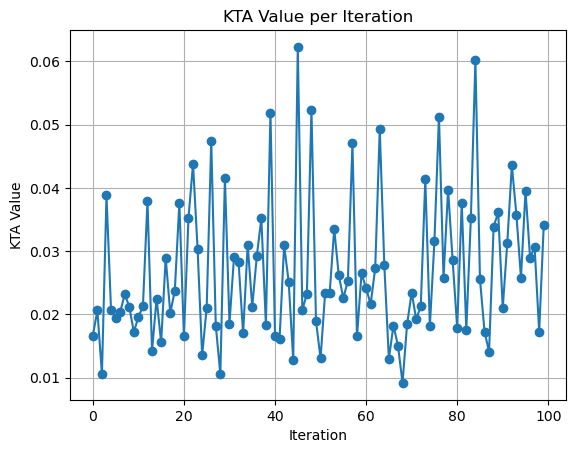

In [77]:
# Update optimization_details dictionary
optimization_details = {
    'Optimization Method': 'Gradient Ascent',
    'Num Qubits': num_features,
    'Num Iterations': num_iterations,
    'SVM Train Score': train_validation,
    'SVM Test Score': test_validation,
    'KTA List': kta_values,
    'Optimised Weights': optimal_theta.tolist()
}

# Check if CSV file already exists and append or save new data
csv_file_path = 'gradient_ascent_optimization_details.csv'
if os.path.isfile(csv_file_path):
    df_existing = pd.read_csv(csv_file_path)
    df_new = pd.DataFrame([optimization_details])
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    df_combined.to_csv(csv_file_path, index=False)
else:
    df = pd.DataFrame([optimization_details])
    df.to_csv(csv_file_path, index=False)

print(f"Optimization details saved to {csv_file_path}")

# Plot the KTA values over iterations (style modified to match second code)
plt.plot(kta_values[-100:], marker='o')
plt.xlabel('Iteration')
plt.ylabel('KTA Value')
plt.title('KTA Value per Iteration')
plt.grid(True)
plt.show()



In [67]:
train_vali3, test_vali3 = train_validation, test_validation

In [62]:
train_vali2, test_vali2 = train_validation, test_validation

In [77]:
# Set optimization parameters
initial_learning_rate = 30
decay_rate = 1
num_iterations = 10
batch_size = 10
#theta = [3.55102703827831, 3.9451707852926354, 1.5014911517997618, 0.8790446062723056]
theta = np.random.uniform(0,2*np.pi,num_features)
kta_values = []
t1 = time.time()
# Gradient ascent optimization loop with variable learning rate
for iteration in range(num_iterations):
    # Calculate the current learning rate based on the decay schedule
    current_learning_rate = initial_learning_rate * (decay_rate ** iteration)

    # Randomly select a batch of data points
    idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
    X_batch = X_train[idx]
    Y_batch = Y_train[idx]

    # Compute the gradient using this batch
    gradient = KTA_gradient(theta, X_batch, Y_batch, y_outer)
    update = [current_learning_rate * gradient[i] for i in range(num_features)]
    # Update the parameter using the variable learning rate
    theta = [theta[i] + update[i] for i in range(num_features)]
    print(theta[0],theta[1], theta[2],theta[3])
    # Print the learning rate and iteration for monitoring
    #print(f"Iteration {iteration + 1} - Learning Rate: {current_learning_rate:.4f}")
    #print("Updated theta:", theta)



# Extract the optimal theta from the result
optimal_theta = theta
print("Optimal theta:", optimal_theta)
kta_values1 = []
t2 = time.time()
print(t2-t1, 'seconds')
# Calculate and display the maximum KTA using optimal theta
bound_map_optimal = feature_map.assign_parameters({training_params[i]: optimal_theta[i] for i in range(num_features)})
kernel_matrix_train_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_train)
kernel_matrix_test_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_test, y_vec=X_train)
quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test)


C:\Users\AVisha\AppData\Local\Temp\ipykernel_16904\3809649190.py:60: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_original = feature_map.bind_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
C:\Users\AVisha\AppData\Local\Temp\ipykernel_16904\3809649190.py:64: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_shifted = feature_map.bind_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})


0.015106219743464296
1.9459328372433564 1.587523816562905 2.34408574370245 0.5544329949770582
0.026788840790510637
2.0119272657070235 1.5911918631585336 2.502932342597707 0.4199491315566489
0.03120054639288575
2.060998970323456 1.5928779539047226 2.513035025038323 0.40728287955107134
0.02910053740875844
2.0953307383769086 1.5951957822298273 2.60709740063516 0.3273371733501701
0.03117870366239201
2.1020779504368075 1.5956974069091217 2.706666669506718 0.29528102103422993
0.03100358225961325
2.0851288382189175 1.5963212972235323 2.67384200100259 0.29331222621955255
0.03185450914327482
2.102031371758393 1.5960331377272678 2.651362703828896 0.31022230747148327
0.029021877076449612
2.162251113243461 1.5952183915400846 2.7583714602681044 0.21635591572879143
0.028850176783012108
2.213082398570197 1.5971036171615298 2.813817265194606 0.21302920359385913
0.033178745012250314
2.1989620147496596 1.5968949153556926 2.833925623506394 0.26370153513296246
Optimal theta: [2.1989620147496596, 1.5968949

C:\Users\AVisha\AppData\Local\Temp\ipykernel_16904\1154875625.py:39: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_map_optimal = feature_map.bind_parameters({training_params[i]: optimal_theta[i] for i in range(num_features)})


Precomputed kernel classification test score: 0.52


In [ ]:
# Plot the kernel matrices
#plot_matrix(kernel_matrix_train, kernel_matrix_test, kernel_matrix_train_optimal, kernel_matrix_test_optimal)

def KTA_gradient(thetas, X, Y, y_outer, indices_to_optimize, delta_theta=1e-6):
    gradients = np.zeros_like(thetas) # Initialize gradients array
    for i in indices_to_optimize: # Loop only over the indices you want to optimize
        theta_shifted = np.copy(thetas)
        theta_shifted[i] += delta_theta

        bound_map_original = feature_map.assign_parameters({training_params[j]: thetas[j] for j in range(len(thetas))})
        kernel_matrix_train_original = kernel(bound_map_original).evaluate(x_vec=X)
        kta_original = KTA(kernel_matrix_train_original, Y, y_outer)

        bound_map_shifted = feature_map.assign_parameters({training_params[j]: theta_shifted[j] for j in range(len(thetas))})
        kernel_matrix_train_shifted = kernel(bound_map_shifted).evaluate(x_vec=X)
        kta_shifted = KTA(kernel_matrix_train_shifted, Y, y_outer)

        gradient = (kta_shifted - kta_original) / delta_theta
        gradients[i] = gradient # Store gradient for this index
    kta_values1.append(kta_original)
    print(kta_original)
    return np.array(gradients)



# Set optimization parameters
initial_learning_rate = 30
decay_rate = 1
num_iterations = 100
batch_size = 100
theta = np.random.uniform(0,2*np.pi,num_features)
#theta = [3.4867625820217967, 0.8316407873036624, 0.47750437975791016, 1.1851710629562362]
#theta = [1.2566370614359172, 3.141592653589793, 2.5132741228718345, 0.0]
#theta = [5.026548245743669, 0.0, 1.8849555921538759, 0.0]
indices_to_optimize = random_indices = np.random.choice(range(len(theta)), 2, replace=False)
t3 = time.time()
# Gradient ascent optimization loop with variable learning rate
for iteration in range(num_iterations):
    # Calculate the current learning rate based on the decay schedule
    current_learning_rate = initial_learning_rate * (decay_rate ** iteration)

    # Randomly select a batch of data points
    idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
    X_batch = X_train[idx]
    Y_batch = Y_train[idx]

    # Compute the gradient using this batch
    gradient = KTA_gradient(theta, X_batch, Y_batch, y_outer, indices_to_optimize)

    # Randomly select two indices for updating


    # Update only the selected theta parameters
    for i in random_indices:
        theta[i] += current_learning_rate * gradient[i]

    indices_to_optimize = random_indices = np.random.choice(range(len(theta)), 2, replace=False)
    # You can continue with the rest of your code here, such as computing the kernel matrix, etc.

    print(theta[0],theta[1], theta[2],theta[3])


# Extract the optimal theta from the result
optimal_theta = theta
print("Optimal theta:", optimal_theta)
t4 = time.time()
print(t4-t3, 'Seconds')

# Calculate and display the maximum KTA using optimal theta
bound_map_optimal = feature_map.assign_parameters({training_params[i]: optimal_theta[i] for i in range(num_features)})
kernel_matrix_train_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_train)
kernel_matrix_test_optimal = kernel(bound_map_optimal).evaluate(x_vec=X_test, y_vec=X_train)
quantum_svm(kernel_matrix_train_optimal, kernel_matrix_test_optimal, Y_train, Y_test)













# Measure execution time
time2 = time.time()
print("Execution time:", time2 - time1)


'''
import itertools
import pickle

num_theta_steps = 10
best_kta = 0.0
num_features = len(training_params)
best_theta = [0.0] * num_features

theta_values = []  # To store the theta values
kta_values = []    # To store the KTA values

import itertools
for steps in itertools.product(range(num_theta_steps), repeat=num_features):
    current_theta = [step * (2 * np.pi) / num_theta_steps for step in steps]
    theta_values.append(current_theta)


    # Create a binding dictionary for all the theta values
    binding_dict = {training_params[i]: current_theta[i] for i in range(num_features)}

    # Bind the current theta values to the feature map
    bound_map = feature_map.bind_parameters(binding_dict)
    kernel_matrix_train_current = kernel(bound_map).evaluate(x_vec=X_train)

    # Calculate KTA for the current theta values
    kta = KTA(kernel_matrix_train_current, Y_train, y_outer)
    kta_values.append(kta)
    # Update best theta and KTA if necessary
    if kta > best_kta:
        best_kta = kta
        best_theta = current_theta

    # Print current progress
    progress = '/'.join(map(str, steps))
    print(f"Step {progress}/{num_theta_steps} - Current KTA: {kta:.4f}")


# Saving theta and KTA values
with open('theta_values.pkl', 'wb') as f:
    pickle.dump(theta_values, f)
with open('kta_values.pkl', 'wb') as f:
    pickle.dump(kta_values, f)

# Print the best theta and corresponding KTA
print("Best Theta:", best_theta)
print("Best KTA:", best_kta)

In [ ]:
pip install itertools

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [ ]:
pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import itertools
import pickle

num_theta_steps = 10
best_kta = 0.0
num_features = 4
best_theta = [0.0] * num_features

theta_values = []  # To store the theta values
kta_values = []    # To store the KTA values

import itertools
for steps in itertools.product(range(num_theta_steps), repeat=num_features):
    current_theta = [step * (2 * np.pi) / num_theta_steps for step in steps]
    theta_values.append(current_theta)


    # Create a binding dictionary for all the theta values
    binding_dict = {training_params[i]: current_theta[i] for i in range(num_features)}

    # Bind the current theta values to the feature map
    bound_map = feature_map.assign_parameters(binding_dict)
    kernel_matrix_train_current = kernel(bound_map).evaluate(x_vec=X_train)

    # Calculate KTA for the current theta values
    kta = KTA(kernel_matrix_train_current, Y_train, y_outer)
    kta_values.append(kta)
    # Update best theta and KTA if necessary
    if kta > best_kta:
        best_kta = kta
        best_theta = current_theta

    # Print current progress
    progress = '/'.join(map(str, steps))
    print(f"Step {progress}/{num_theta_steps} - Current KTA: {kta:.4f}")


# Saving theta and KTA values
with open('theta_values.pkl', 'wb') as f:
    pickle.dump(theta_values, f)
with open('kta_values.pkl', 'wb') as f:
    pickle.dump(kta_values, f)

# Print the best theta and corresponding KTA
print("Best Theta:", best_theta)
print("Best KTA:", best_kta)


NameError: ignored

 Volume in drive C is OS
 Volume Serial Number is EC39-625B

 Directory of C:\Users\AVisha\OneDrive - Secqai\Old\Quantum Kernel Methods

25/01/2024  23:04    <DIR>          .
25/01/2024  20:23    <DIR>          ..
25/01/2024  20:27    <DIR>          .ipynb_checkpoints
25/01/2024  23:00    <DIR>          cifar-10-python
25/01/2024  20:30       170,498,071 cifar-10-python.tar.gz
25/01/2024  20:23            91,303 RBF_kernel.ipynb
25/01/2024  23:04            76,244 ZZ_feature_Map.ipynb
               3 File(s)    170,665,618 bytes
               4 Dir(s)  775,630,245,888 bytes free
